### Vi prøver igen ...

Her er der taget det største datasæt jeg kan finde.

I denne model har jeg strengt opdelt i "train" og "test" data. Den forrige model var forkert på en eller anden måde. Alt ser rigtigt ud, men den nåede 100% korrektned straks. Det er meget mistænkeligt, men jeg slet ikke se fejlen. Derfor laver jeg modellen igen med en stræng opdeling. 

Her viser det sig, at modellen er ret ringe til at forudsige antal stragegilinjer ud fra den skrevne tekst. Men det er også en svær disciplin. Det handler om at finde de 2% af linjerne, hvor der er noget stort. Det er en slags "abnormality detection".

Nedenfor er et par eksempler på hvordan data rigtigt ser ud. I eksemplet er en kort tekst med otte strategilinjer. OG den timsvarende omsættelse til rådata til modellen.

![title](FEDentry.GIF)
![title](FEDentry2.GIF)

### Konklusion
Med nogle flere data, nu træning på ca 72.000 rækker, bliver præcisionen noget bedre, men langt fra i mål. Lige nu opnår jeg en fin forskel på rigtig og forkert, men ikke i nærheden af 0/1:
- 0.22  gennemsnit værdi for "rigtig"
- 0.03  gennemsnit værdi for "forkert"

Modellen er ikke rigtig stærk til at spotte rigtig. 
Jeg må dog også konstatere, at dette hele tiden har været et forsæg, hvor jeg godt vidste at der ikke var en stærk sammenhæng, men jeg jeg præver alliegel at få mest muligt ud af systemet. Jeg har lagt mærke til, at "snad" og falsk dog falder i adskilte grupper. Der ser ud til at være en skillelinje omkring 0.1. Hvis det bruges som trigger, så har modellen dog en præcision på 27%. Der er ca 3% store, så modellen er ca 10 gange bedre end tilfældigt.

In [1]:
# vi sætter stien til data
import os
import pandas as pd
import numpy as np
os.chdir('/Users/ThomasGordon/Documents/PythonScripts/FED')
os.listdir()

['.ipynb_checkpoints',
 'FEDAlt_All_texts.xlsx',
 'FEDAlt_test.xlsx',
 'FEDAlt_train.xlsx',
 'FEDData.xlsx',
 'FEDData_All_texts.xlsx',
 'FEDData_test.xlsx',
 'FEDData_train.xlsx',
 'FEDentry.GIF',
 'FEDentry2.GIF',
 'FED_01_FirstModel.ipynb',
 'FED_02_SplitTrainOgTest.ipynb',
 'FED_03_SplitTrainOgTest_AllData.ipynb']

Først laver vi en "dictionary", som omsætter ord til tal. Den bruges efterfølgende til at omsætte train data og test data.

In [2]:
# filen med tekster åbnes og indlæses
file = 'FEDAlt_All_texts.xlsx'
xl = pd.ExcelFile(file)
df = xl.parse('FEDlinjer')

# strenge læses over i en tabel
texts  = df.loc[:,'FEDtext']
texts  = texts.values

# henter text processing modul
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 10000  # Vi ser kun på de 10.000 mest almindelige ord

# vi laver ordene i FED om til tilsvarende tal (som igen kan laves til en "one-hot)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# en funktion som lave en one-hot vektorer
def vectorize_sequences(sequences, dimension=10000):
    # lave en all-zero matrix af formen (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

In [4]:
# Træningsdata indlæses (tekster og labels), først tekst-strengene
file = 'FEDAlt_train.xlsx'
xl = pd.ExcelFile(file)
df = xl.parse('FEDlinjer')
texts  = df.loc[:,'FEDtext']
labels = df.loc[:,'FEDsize']
FEDid  = df.loc[:,'FEDid']
texts  = texts.values
labels = labels.values

# ord laves til og der "paddes"
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences)

# One-hot training data
data = vectorize_sequences(data, dimension=max_words)

# labels laves til vektor
labels = np.asarray(labels).astype('float32')

In [5]:
print(data.shape)
print(labels.shape)

(89998, 10000)
(89998,)


In [6]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(data, labels,
                    epochs=20,
                    batch_size=512,
                    validation_split=0.2)

Train on 71998 samples, validate on 18000 samples
Epoch 1/20
71998/71998 [==============================] - 17s 234us/step - loss: 0.3309 - acc: 0.9551 - val_loss: 0.1593 - val_acc: 0.9640
Epoch 2/20
71998/71998 [==============================] - 16s 225us/step - loss: 0.1720 - acc: 0.9621 - val_loss: 0.1319 - val_acc: 0.9644
Epoch 3/20
71998/71998 [==============================] - 14s 199us/step - loss: 0.1483 - acc: 0.9627 - val_loss: 0.1307 - val_acc: 0.9653
Epoch 4/20
71998/71998 [==============================] - 15s 212us/step - loss: 0.1417 - acc: 0.9634 - val_loss: 0.1321 - val_acc: 0.9653
Epoch 5/20
71998/71998 [==============================] - 15s 209us/step - loss: 0.1387 - acc: 0.9638 - val_loss: 0.1335 - val_acc: 0.9655
Epoch 6/20
71998/71998 [==============================] - 15s 214us/step - loss: 0.1332 - acc: 0.9640 - val_loss: 0.1347 - val_acc: 0.9654
Epoch 7/20
71998/71998 [==============================] - 16s 220us/step - loss: 0.1303 - acc: 0.9648 - val_loss: 0.

In [8]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

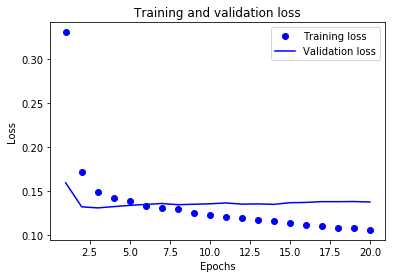

In [10]:
import matplotlib.pyplot as plt

accu = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs = range(1, len(history_dict['binary_accuracy']) + 1)
epochs = range(1, 21)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

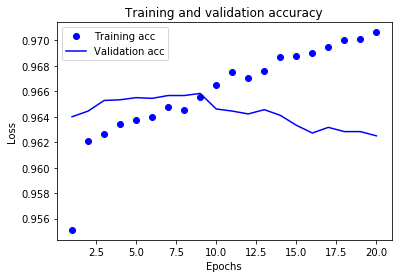

In [11]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Validering af modellen på test data
Her indlæser vi så test data, helt nye data til test

In [12]:
# Træningsdata indlæses (tekster og labels), først tekst-strengene
file = 'FEDAlt_test.xlsx'
xl = pd.ExcelFile(file)
df = xl.parse('FEDlinjer')
texts_test  = df.loc[:,'FEDtext']
labels_test = df.loc[:,'FEDsize']
FEDid_test  = df.loc[:,'FEDid']
texts_test  = texts_test.values
labels_test = labels_test.values
FEDid_test  = FEDid_test.values

# ord laves til og der "paddes"
sequences_test = tokenizer.texts_to_sequences(texts_test)
data_test = pad_sequences(sequences_test)

# One-hot training data
data_test = vectorize_sequences(data_test, dimension=max_words)

# labels laves til vektor
labels_test = np.asarray(labels_test).astype('float32')

In [13]:
# vi prøver modellen på test-data
predictions = model.predict(data_test)

# vi printer min, max og nogle eksempler
print(min(predictions), max(predictions))
SplitVal = (min(predictions) + max(predictions))/2

# print(predictions[1:20])

for i in range(1,20):
    print(('%1.4f' % predictions[i]))

[2.0294502e-09] [0.99979407]
0.0008
0.0009
0.0003
0.0107
0.1127
0.0021
0.0111
0.1134
0.0008
0.0326
0.0035
0.0353
0.0076
0.0356
0.0217
0.0354
0.0112
0.0295
0.0155


In [14]:
print('Antal store i datasættet:    ', sum(labels_test))

NumEstimated = 0
for i in range(1,6000):
    if predictions[i]>0.1 and FEDid_test[i]<=3793:
        NumEstimated += 1
print('antal estimeret af modellen: ', NumEstimated)

print('Modellens præcision:         ', round(NumEstimated/sum(labels_test)*100), '%')

Antal store i datasættet:     420.0
antal estimeret af modellen:  113
Modellens præcision:          27.0 %


In [16]:
# C-style måde at finde gennemsnittet for dem som er rigtige
AvgPositive = 0
PosCounter = 0
for i in range(0,len(labels_test)):
    if labels_test[i]:
        AvgPositive += predictions[i]
        PosCounter += 1
AvgPositive = AvgPositive / PosCounter
print('%.2f  gennemsnit værdi for "rigtig"' % AvgPositive)

# C-style måde at finde gennemsnittet for dem som er FORKERTE
AvgPositive = 0
PosCounter = 0
for i in range(0,len(labels_test)):
    if labels_test[i] == 0:
        AvgPositive += predictions[i]
        PosCounter += 1
AvgPositive = AvgPositive / PosCounter
print('%.2f  gennemsnit værdi for "forkert"' % AvgPositive)

0.21  gennemsnit værdi for "rigtig"
0.03  gennemsnit værdi for "forkert"


In [17]:
# jeg prøver at printe linjenummer, prediction og tekststreng for dem som er store = "rigtige"

for i in range(1,6000):
    if labels_test[i]==1:
        PrtStr = ('%4.0f' % i) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts_test[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 

   5  0.1127  K -12 u Mst.. Signalfejl Trg..
  90  0.5477  1408 har påkørt en person mellem HUM og NI.
 103  0.1308  Har påkørt en bil i OVK 115 mellem RØB og EST.       U- Vagt  Pt bliver de 8 passager i toge
 107  0.1080  Holder i Kd nedbrudt
 138  0.5474  Signalfejl : Svendborgbanen - pronose er, at der resten af dagen skal vendes i Stenstrup. Der fortsæ
 141  0.0449  Lkf til 8302 i Ar., har sygemeldt sig. Og nat-Rdg kan ikke køre ME+DD.. Derfor:
 173  0.0018  Hgl. kan levere nogle sæt til 9338 (3 sæt). Det giver materiel udfordringer i KAC
 192  0.4697  Bdk har mistet kontrollen over et sporskifte i Re.
 210  0.0124  Fokustog for Fredag d. 9. september 2011.
 216  0.0703  F -?? u Kk... Dørfejl.. Lkf er ved at aflåse flere yderdøre..
 241  0.0934  Korrigering. Manglende korrigering af sporarbejde Htå-Hif til aften. Ikke lavet af formiddagsholdet,
 289  0.8049  Mulig ild i en køreledning på Lillebæltsbroen. L 40 er først tog, og efterseer.
 299  0.0437  Kørt fra Ar mod Vy, vi kører t

### Modellen er ikke specielt præcis. jeg checker lige efter på træninsdata, dem kan man håbe den har lært bedre at kende???

In [18]:
# vi prøver modellen på test-data
predictions = model.predict(data)

# vi printer min, max og nogle eksempler
print(min(predictions), max(predictions))
SplitVal = (min(predictions) + max(predictions))/2

# print de første predictions
for i in range(1,20):
    print(('%1.4f' % predictions[i]))

[9.0410956e-11] [0.9999987]
0.0092
0.0232
0.0019
0.0688
0.0718
0.1541
0.0007
0.0038
0.0313
0.0238
0.0242
0.0139
0.0000
0.0013
0.0968
0.0329
0.0224
0.0329
0.0090


In [44]:
print('Antal store i datasættet:    ', sum(labels))

NumEstimated = 0
for i in range(1,len(labels)):
    if predictions[i]>0.4 and labels[i]==1:
        NumEstimated += 1
print('antal estimeret af modellen: ', NumEstimated)

print('Modellens præcision:         ', round(NumEstimated/sum(labels)*100), '%')

Antal store i datasættet:     3373.0
antal estimeret af modellen:  1169
Modellens præcision:          35.0 %


In [20]:
# jeg prøver at printe linjenummer, prediction og tekststreng, som er rigtige (store)

for i in range(1,len(labels)):
    if labels[i]==1:
        PrtStr = ('%4.0f' % i) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 

   6  0.1541  Nedformeringer fra Sverige.
  16  0.0329  Pga de tre groundede MF-sæt i Fa., kniber det lidt med materiellet.. Derfor:
  44  0.0672  00:34 Nedbrudt i Svv. Kan kun køre mod Svg, dette gøres. 3 pass i toget taxabefordres. Taxa bestilt 
  89  0.9761  Tif og Epi  Vi er ikke blevet helt færdigt med weekendens sporarbejde mellem Københavns Lufthavn
  99  0.7291  Der mangler 1 ME til morgentrafikken følgende tiltag iværksættes
 166  0.9402  Manglende Lkf Kh, udeblivelse og efterveer efter mandagen samt generelle mangler plus sygemeldinger
 178  0.0623  Grundet mgl på køreklart materiel (vogne og ER4) laves følgede
 206  0.8098  Signalfejl: Alle blok afsnit mellem Lk og Es er gået ned og der bliver kørt på sigt.
 228  0.4370  Holder med brandalarm på vej ud af Vo.
 232  0.1541  Nedformeringer fra Sverige
 314  0.0363  Må ikke køre længere end Kh og til rep
 338  0.4185  Der mangler 1 BR mandag
 352  0.0822  Materiel   holder i RE med fejl på en fjederbremse.
 362  0.0757  signalf

32467  0.0315  MAterielfejl MG :
32525  0.0882  Materiel    Holder i BD med fejl på toget.
32560  0.0701  Materielfejl gået istå på vej op til perron i Cph.
32583  0.0671  ET mangel
32638  0.8565  Banedanmark har gravet et kabel over ved Marslev. FST-fejl Uv-Mv. Uv og Mv kan ikke fjernstyres.
32663  0.9129  Info: Vi kan i øjeblikket ikke køre mellem København H og Københavns Lufthavn. Det skyldes en person
32671  0.3237  05:05: Signalfejl STS - SVG
32685  0.0183  Manglende materiel
32707  0.0336  Pga. forventet mgl ER: BEMÆRK 18/12
32800  0.1251  Nedformeringer fra Malmø
32816  0.9976  Laskefejl mellem Hp-Od i vestgående retning (hændelsen startede kl. 9.58).
32838  0.1186  ME på KH:
32876  0.2435  Problemer i Cph, der køres ingen tog mellem Kh - Cph
32897  0.6628  Strategi Fa: man forventes at 56424 er den første der kører igennem fra vest
32920  0.0516  Materielmgl. NF. DD 1212 Torsdag
32977  0.2864  Sporskifte fejl i øst enden.
33051  0.9997  Disponering DSB : opstart af 14xx system

59107  0.0871  Røgdetektorfejl... Sættet pilles af og efterlades... Der er ikke noget at erstatte med...
59113  0.5352  Vi mangler tre stammer i Nf til morgentrafikken. Det giver lidt omslag og aflysninger:
59115  0.9741  Træ hænger på køreledningen, tog trafikken indstillet NI-HG-Ni . 20xx
59119  0.0054  Korrigering. Lokoførerture hænger ikke sammen. I stedet laver vi flere skarpe vendinger på Kk. Evt. 
59125  0.6818  Sporskiftefejl GT : Standardprognose en time
59175  0.9999  HQ: Blokuorden Hq-Vn + Vn-Hq SE DRAP.1970528  •                    Trafikal vurdering : Forsin
59212  0.0373  Forsinket over fyn. grundet nedbrud på vestfyn.
59220  0.1334  Mgl. 2 ER på KK til morgentrafikken
59225  0.0527  Materiel af ET materiel.
59258  0.9638  00:44 Spærringen ved Kd forventes ophævet kl ca 01:00.
59294  0.1026  sporskifte fejl i SO
59304  0.7674  Vi mangler til IC og lyntog, så for at frigive togsæt til dette, ændrer vi på materieltype og vendin
59315  0.6205  Sporskifte ude af kontrol i Gl 

75073  0.1392  Mgl en ET til følgende tog 1326 / 1330 / 1332 / 1334 / 1336 i NI
75083  0.1186  Godstog 37700 gået i stå mellem Fj og Rg. 51140 forberedes på, at køre retur til Fj og ad V spor Fj-
75085  0.0327  Kommer med 2 ER normalt 3 MF
75093  0.0000  Medgives to aflåste ER-sæt Fa - Kh.. Togsættene skal videre til Hgl for eftersyn..
75157  0.0484  materielfejl MG : fejl på hastighedsmåler
75174  0.0593  Der er def skifte på KH ved spor 4 ud mod KK.
75221  0.0073  Forsinket fra Sverige pga signalfejl, vi kører en tur Kh-Ru-Kh med resstm
75241  0.1526  Disponering i Helsingør pga. nedformeringer fra Sverige.
75242  0.2326  Sporskiftefejl Klv
75266  0.0159  Hgl. Oscillator-fejl. Mange falske besættelser. Sporskifter kan omstilles med smuto. Togkørsel med i
75275  0.6204  Banedanmark        Et muligt skinnebrud mellem SG - SO             Startede med en signalfejl.
75291  0.0114  Fejl på tysk radio, vi kan ikke få fejl væk, trods flere forsøg, så der omdisponeres.
75368  0.0084  Har mat

In [21]:
# jeg prøver at printe linjenummer, prediction og tekststreng, som er FORKERTE (små)

for i in range(1,200):
    if labels[i]==0:
        PrtStr = ('%4.0f' % i) + '  ' + ('%1.4f' % predictions[i]) + '  ' + texts[i][:100].replace('\n', ' ').replace('\r', '')
        print(PrtStr) 

   1  0.0092  Lkf. mente han havde ramt noget mellem HK-RT. Lkf. kiggede efter men kunne ikke se noget.  1524 ki
   2  0.0232  Umiddelbart efter afg Lih fortæller Lkf at togsættet meldes nedbrudt ved ank Ab.. Fejl på fejl på 
   3  0.0019  Der er ikke nogen virksomme toiletter i toget. Vi tager rørløbet og kører i BLV og tømmer det.
   4  0.0688  Problemer med at skille af i Nf. LKI tager kontakt.
   5  0.0718  Kører fra Kk med dørfejl, som fejlrettes på Kn ! LKI har bedt lkf om at tømme toget på Kn og komme
   7  0.0007  Der ingen lkf til klargøring P-risten kan ikke hjælpe, det ville har været ok bare de kunne ha start
   8  0.0038  Placering af 2 MR til, at dække togsæt mangler i Es.
   9  0.0313  Disponering DSB.
  10  0.0238  Mgl en ER i FA til 953 da den ikke kom med i 51053 Fra KH pga. den var frossen
  11  0.0242  Materiel
  12  0.0139  Nedbrud hjem til rep.
  13  0.0000  IC4 erstattes med IC3 med vg 91-92.
  14  0.0013  Materielfejl ER : ingen virksomme toiletter
  15  0.0968 

In [22]:
# C-style måde at finde gennemsnittet for dem som er rigtige
AvgPositive = 0
PosCounter = 0
for i in range(0,len(labels)):
    if labels[i]:
        AvgPositive += predictions[i]
        PosCounter += 1
AvgPositive = AvgPositive / PosCounter
print('%.2f gennemsnit værdi for "rigtig" for train data' % AvgPositive)

# C-style måde at finde gennemsnittet for dem som er forkerte
AvgPositive = 0
PosCounter = 0
for i in range(0,len(labels)):
    if labels[i] == 0:
        AvgPositive += predictions[i]
        PosCounter += 1
AvgPositive = AvgPositive / PosCounter
print('%.2f gennemsnit værdi for "forkerte" for train data' % AvgPositive)

# Phytonic måde at gøre det samme på !!!
print(np.average([x for i, x in enumerate(predictions) if labels[i]]))
print(np.average([x for i, x in enumerate(predictions) if not labels[i]]))

0.33 gennemsnit værdi for "rigtig" for train data
0.03 gennemsnit værdi for "forkerte" for train data
0.32652864
0.027004417


In [39]:
PlotData = [x for i, x in enumerate(predictions) if labels[i]]
PlotData = np.array(PlotData)
print(PlotData[:20])
print(predictions[:20])

[[0.15406838]
 [0.03286549]
 [0.06716431]
 [0.9761397 ]
 [0.72914755]
 [0.9401629 ]
 [0.06230074]
 [0.80975467]
 [0.43698925]
 [0.15406838]
 [0.03634684]
 [0.41847247]
 [0.08216202]
 [0.07567933]
 [0.66356677]
 [0.12118326]
 [0.57081884]
 [0.08022175]
 [0.9280329 ]
 [0.72009665]]
[[5.0348667e-03]
 [9.2165526e-03]
 [2.3232812e-02]
 [1.8592372e-03]
 [6.8783283e-02]
 [7.1795419e-02]
 [1.5406838e-01]
 [6.8592723e-04]
 [3.8497380e-03]
 [3.1292558e-02]
 [2.3764592e-02]
 [2.4186742e-02]
 [1.3919393e-02]
 [3.2263331e-05]
 [1.3199484e-03]
 [9.6780732e-02]
 [3.2865487e-02]
 [2.2401605e-02]
 [3.2936588e-02]
 [9.0426253e-03]]


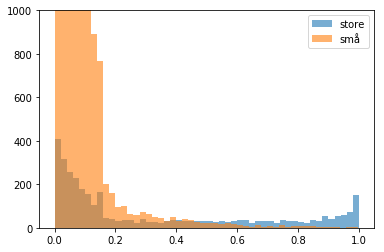

In [49]:
# jeg prøver lige at plotte "predictions i et histogram

# hent data for store og små i to arrays, lav til et np array, så plotteren kan forstå data
PlotDataSand = [x for i, x in enumerate(predictions) if labels[i]]
PlotDataSand = np.array(PlotDataSand)
PlotDataFalsk = [x for i, x in enumerate(predictions) if not labels[i]]
PlotDataFalsk = np.array(PlotDataFalsk)

plt.clf()  # clear figure
plt.hist(PlotDataSand, bins=50, alpha=0.6, label='store')  # 50 bins, halv hennemsigtig
plt.hist(PlotDataFalsk, bins=50, alpha=0.6, label='små')
plt.legend(loc='upper right')
plt.ylim([0, 1000])

plt.show()